In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os, glob, re, json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm, SymLogNorm, CenteredNorm
from censai.data.lenses_tng import decode_train, decode_physical_model_info
from censai import PhysicalModel
from argparse import Namespace
from argparse import Namespace
import math, json
import matplotlib.pylab as pylab
import tensorflow as tf
import h5py
from tqdm import tqdm
import tensorflow_probability as tfp

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 2000)
pd.set_option('display.max_colwidth', 200)

result_dir = os.path.join(os.getenv("CENSAI_PATH"), "results")
data_path = os.path.join(os.getenv("CENSAI_PATH"), "data")
models_path = os.path.join(os.getenv("CENSAI_PATH"), "models")

params = {'legend.fontsize': 'x-large',
#           'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize': 30,#'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)
# plt.style.use("science")

In [2]:
# model = "RIMSU512_k128_NIE2nsvdO_033_TS10_F16_L5_IK11_NLrelu_al0.04_GAplus_42_B10_lr0.0005_dr0.8_ds5000_TWquadratic_210923032150"
model = "RIMSU128_hTNG2nsvdO_Sinit1_001_F16_IK11_NLleaky_relu_128_211012121338"
path = os.path.join(os.getenv("CENSAI_PATH"), "data", "rim_predictions", model, "prediction.h5")
hf = h5py.File(path, 'r')
k = 8

lens = np.array(hf[f"data{k:03d}/lens"]).squeeze()
source = np.array(hf[f"data{k:03d}/source"]).squeeze()
kappa = np.array(hf[f"data{k:03d}/kappa"]).squeeze()
lens_pred = np.array(hf[f"data{k:03d}/lens_pred"]).squeeze()
source_pred = np.array(hf[f"data{k:03d}/source_pred"]).squeeze()[-1]
kappa_pred = np.array(hf[f"data{k:03d}/kappa_pred"]).squeeze()[-1]
chi_squared = np.array(hf[f"data{k:03d}/chi_squared"]).squeeze()[-1]

hf.close();

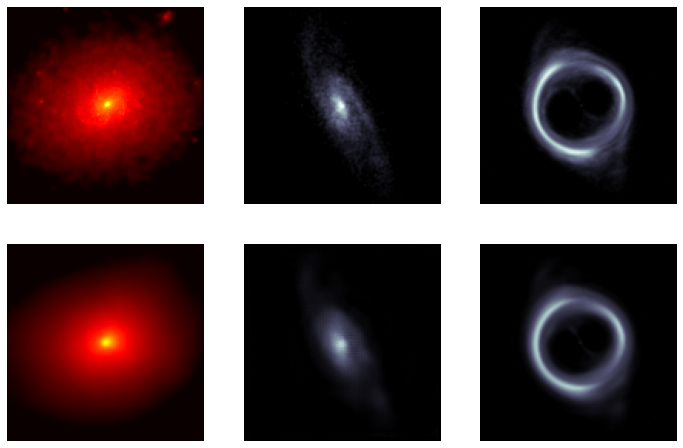

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs[0, 0].imshow(kappa, cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
axs[0, 1].imshow(source, cmap="bone", vmin=0, vmax=1)
axs[0, 2].imshow(lens, cmap= "bone", vmin=0, vmax=1)
axs[1, 0].imshow(kappa_pred, cmap="hot", norm=LogNorm(vmin=0.1, vmax=100))
axs[1, 1].imshow(source_pred, cmap="bone", vmin=0, vmax=1)
axs[1, 2].imshow(lens_pred, cmap= "bone", vmin=0, vmax=1)
for i in range(2):
    for j in range(3):
        axs[i, j].axis("off")

In [4]:
dataset = "lenses128_TNG100_10k_verydiffuse"

files = []
for dataset in [os.path.join(os.getenv('CENSAI_PATH'), "data", dataset)][:1]:
    files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
np.random.shuffle(files)
# Read concurrently from multiple records
files = tf.data.Dataset.from_tensor_slices(files)
dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, compression_type="GZIP"),
                           block_length=1, num_parallel_calls=tf.data.AUTOTUNE)
# Read off global parameters from first example in dataset
for physical_params in dataset.map(decode_physical_model_info):
    break

phys = PhysicalModel(
    pixels=physical_params["pixels"].numpy(),
    kappa_pixels=physical_params["kappa pixels"].numpy(),
    src_pixels=physical_params["src pixels"].numpy(),
    image_fov=physical_params["image fov"].numpy(),
    kappa_fov=physical_params["kappa fov"].numpy(),
    src_fov=physical_params["source fov"].numpy(),
    method="fft",
    noise_rms=physical_params["noise rms"].numpy(),
    psf_sigma=physical_params["psf sigma"].numpy()
)



# Deep prior

In [5]:
from censai.models.layers import UnetDecodingLayer, UnetEncodingLayer
from censai.models.utils import get_activation
from censai.definitions import DTYPE


class UnetPrior(tf.keras.Model):
    def __init__(
            self,
            filters=32,
            filter_scaling=1,
            kernel_size=3,
            layers=2,                        # before bottleneck
            block_conv_layers=2,
            strides=2,
            bottleneck_kernel_size=None,     # use kernel_size as default
            bottleneck_filters=None,
            resampling_kernel_size=None,
            input_kernel_size=11,
            batch_norm=False,
            dropout_rate=None,
            upsampling_interpolation=False,  # use strided transposed convolution if false
            kernel_l1_amp=0.,
            bias_l1_amp=0.,
            kernel_l2_amp=0.,
            bias_l2_amp=0.,
            activation="leaky_relu",
            alpha=0.1,                       # for leaky relu
            use_bias=True,
            trainable=True,
            initializer="glorot_uniform",
    ):
        super(UnetPrior, self).__init__()
        self.trainable = trainable

        common_params = {"padding": "same", "kernel_initializer": initializer,
                         "data_format": "channels_last", "use_bias": use_bias,
                         "kernel_regularizer": tf.keras.regularizers.L1L2(l1=kernel_l1_amp, l2=kernel_l2_amp)}
        if use_bias:
            common_params.update({"bias_regularizer": tf.keras.regularizers.L1L2(l1=bias_l1_amp, l2=bias_l2_amp)})

        kernel_size = (kernel_size,)*2
        resampling_kernel_size = resampling_kernel_size if resampling_kernel_size is not None else kernel_size
        bottleneck_kernel_size = bottleneck_kernel_size if bottleneck_kernel_size is not None else kernel_size
        bottleneck_filters = bottleneck_filters if bottleneck_filters is not None else int(filter_scaling**(layers + 1) * filters)
        activation = get_activation(activation, alpha=alpha)

        self._num_layers = layers
        self._strides = strides
        self._init_filters = filters
        self._filter_scaling = filter_scaling
        self._bottleneck_filters = bottleneck_filters

        self.encoding_layers = []
        self.decoding_layers = []
        self.gated_recurrent_blocks = []
        for i in range(layers):
            self.encoding_layers.append(
                UnetEncodingLayer(
                    kernel_size=kernel_size,
                    downsampling_kernel_size=resampling_kernel_size,
                    filters=int(filter_scaling**(i) * filters),
                    # downsampling_filters=int(filter_scaling ** (i + 1) * filters),
                    conv_layers=block_conv_layers,
                    activation=activation,
                    strides=strides,
                    batch_norm=batch_norm,
                    dropout_rate=dropout_rate,
                    **common_params
                )
            )
            self.decoding_layers.append(
                UnetDecodingLayer(
                    kernel_size=kernel_size,
                    upsampling_kernel_size=resampling_kernel_size,
                    filters=int(filter_scaling**(i) * filters),
                    conv_layers=block_conv_layers,
                    activation=activation,
                    bilinear=upsampling_interpolation,
                    batch_norm=batch_norm,
                    dropout_rate=dropout_rate,
                    **common_params
                )
            )

        self.decoding_layers = self.decoding_layers[::-1]

        self.bottleneck_layer1 = tf.keras.layers.Conv2D(
            filters=bottleneck_filters,
            kernel_size=bottleneck_kernel_size,
            activation=activation,
            **common_params
        )
        self.bottleneck_layer2 = tf.keras.layers.Conv2D(
            filters=bottleneck_filters,
            kernel_size=bottleneck_kernel_size,
            activation=activation,
            **common_params
        )

        self.output_layer = tf.keras.layers.Conv2D(
            filters=2,  # source and kappa
            kernel_size=(1, 1),
            activation="linear",
            **common_params
        )

        self.input_layer = tf.keras.layers.Conv2D(
            filters=filters,
            kernel_size=input_kernel_size,
            activation=activation,
            **common_params
        )

#     def __call__(self, source, kappa, source_grad, kappa_grad):
#         return self.call(source, kappa, source_grad, kappa_grad)

#     def call(self, source, kappa, source_grad, kappa_grad):
#         delta_xt = tf.concat([source, source_grad, kappa, kappa_grad], axis=-1)
#         delta_xt = self.input_layer(delta_xt)
#         skip_connections = []
#         new_states = []
#         for i in range(self._num_layers):
#             c_i, delta_xt = self.encoding_layers[i](delta_xt)
#             skip_connections.append(c_i)
#         skip_connections = skip_connections[::-1]
#         delta_xt = self.bottleneck_layer1(delta_xt)
#         delta_xt = self.bottleneck_layer2(delta_xt)
#         for i in range(self._num_layers):
#             delta_xt = self.decoding_layers[i](delta_xt, skip_connections[i])
#         delta_xt = self.output_layer(delta_xt)
#         source_delta, kappa_delta = tf.split(delta_xt, 2, axis=-1)
#         new_source = source + source_delta
#         new_kappa = kappa + kappa_delta
#         return new_source, new_kappa

    def call(self, noise):
#         delta_xt = tf.concat([source, source_grad, kappa, kappa_grad], axis=-1)
        delta_xt = self.input_layer(noise)
        skip_connections = []
        new_states = []
        for i in range(self._num_layers):
            c_i, delta_xt = self.encoding_layers[i](delta_xt)
            skip_connections.append(c_i)
        skip_connections = skip_connections[::-1]
        delta_xt = self.bottleneck_layer1(delta_xt)
        delta_xt = self.bottleneck_layer2(delta_xt)
        for i in range(self._num_layers):
            delta_xt = self.decoding_layers[i](delta_xt, skip_connections[i])
        delta_xt = self.output_layer(delta_xt)
        source_delta, kappa_delta = tf.split(delta_xt, 2, axis=-1)
        return source_delta, kappa_delta


In [6]:
# prior = UnetPrior(
#     filters=4,
#     filter_scaling=2,
#     kernel_size=3,
#     layers=3,                        # before bottleneck
#     block_conv_layers=2,
#     strides=2,
#     input_kernel_size=11,
#     resampling_kernel_size=3,
#     batch_norm=True,
#     dropout_rate=None,
#     upsampling_interpolation=True,  # use strided transposed convolution if false
#     kernel_l1_amp=0.0,
#     bias_l1_amp=0.0,
#     kernel_l2_amp=0.,
#     bias_l2_amp=0.,
#     activation="leaky_relu",
#     alpha=0.1,                       # for leaky relu
#     use_bias=True,
#     trainable=True,
#     initializer="glorot_uniform",
# )

In [7]:
# a = tf.random.normal(shape=(1, 128, 128, 1))
# # prior.call(a, a, a, a); # build model
# prior.call(a);
# # prior.trainable_variables

In [8]:
# DTYPE = tf.float32
# STEPS = 1000
# SAVE = 100

# optim = tf.keras.optimizers.Adam(lr=1e-4)
# source_o = tf.Variable(tf.identity(source_pred)[None, ..., None], DTYPE)
# kappa_o = tf.Variable((tf.math.log(tf.identity(kappa_pred)[None, ..., None], DTYPE) + 1e-3)/tf.math.log(10.))
# lensed_image = lens

# # with tf.GradientTape() as g:
# #     g.watch(source_o)
# #     g.watch(kappa_o)
# #     y_pred = phys.forward(source=source_o, kappa=10**kappa_o)
# # #         lam = tf.reduce_sum(y_pred * lensed_image[None, ..., None]) / tf.reduce_sum(lensed_image**2)
# #     log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2)
# # source_grad, kappa_grad = g.gradient(log_likelihood, [source_o, kappa_o])

# noise = tf.random.normal(shape=source_o.shape)

# source_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# kappa_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# chi_squared_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# lens_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
# for current_step in tqdm(range(STEPS)):
#     with tf.GradientTape() as g:
#         g.watch(prior.trainable_variables)
# #         source_op, kappa_op = prior(source_o, kappa_o, tf.nn.tanh(source_grad), tf.nn.tanh(kappa_grad))
#         delta_source, delta_kappa = prior(noise)
#         y_pred = phys.forward(source=source_o - delta_source, kappa=10**(kappa_o - delta_kappa))
#         log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2)
#     gradients = g.gradient(log_likelihood, prior.trainable_variables)
#     optim.apply_gradients(zip(gradients, prior.trainable_variables))
# #     with tf.GradientTape() as g:
# #         g.watch(kappa_o)
# #         y_pred = phys.forward(source=source_o, kappa=kappa_o)
# #         log_likelihood = 0.5 * tf.reduce_mean(tf.square(lensed_image - y_pred)/phys.noise_rms**2, axis=(1, 2, 3))
# #     kappa_grad = g.gradient(cost, kappa_o)
# #     optim.apply_gradients(zip([kappa_grad], [kappa_o]))
    
#     if current_step % SAVE == 0:
#         source_series = source_series.write(index=current_step//SAVE, value=source_o - delta_source)
#         kappa_series = kappa_series.write(index=current_step//SAVE, value=kappa_o - delta_kappa)
# #         source_series = source_series.write(index=current_step//SAVE, value=source_op)
# #         kappa_series = kappa_series.write(index=current_step//SAVE, value=kappa_op)
#         chi_squared_series = chi_squared_series.write(index=current_step//SAVE, value=log_likelihood)
#         lens_series = lens_series.write(index=current_step//SAVE, value=y_pred)
  
# source_series = source_series.write(index=STEPS//SAVE, value=source_o - delta_source)
# kappa_series = kappa_series.write(index=STEPS//SAVE, value=kappa_o - delta_kappa)
# # source_series = source_series.write(index=STEPS//SAVE, value=source_op)
# # kappa_series = kappa_series.write(index=STEPS//SAVE, value=kappa_op)
# chi_squared_series = chi_squared_series.write(index=STEPS//SAVE, value=log_likelihood)
# lens_series = lens_series.write(index=STEPS//SAVE, value=y_pred)
# s, k, c, y = source_series.stack(), kappa_series.stack(), chi_squared_series.stack(), lens_series.stack()

In [9]:
source_pred = source_pred[None, ..., None]
kappa_pred = kappa_pred[None, ..., None]

# Vanilla optimization

In [109]:
DTYPE = tf.float32
STEPS = 100
SAVE = 10

optim = tf.keras.optimizers.Adam(lr=1e-4)
source_o = tf.Variable(tf.identity(source_pred), DTYPE)
kappa_o = tf.Variable((tf.math.log(tf.identity(kappa_pred), DTYPE) + 1e-3)/tf.math.log(10.))
lensed_image = lens

# with tf.GradientTape() as g:
#     g.watch(source_o)
#     g.watch(kappa_o)
#     y_pred = phys.forward(source=source_o, kappa=10**kappa_o)
# #         lam = tf.reduce_sum(y_pred * lensed_image[None, ..., None]) / tf.reduce_sum(lensed_image**2)
#     log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2)
# source_grad, kappa_grad = g.gradient(log_likelihood, [source_o, kappa_o])

noise = tf.random.normal(shape=source_o.shape)

source_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
kappa_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
chi_squared_series = tf.TensorArray(DTYPE, size=STEPS+1)
source_mse = tf.TensorArray(DTYPE, size=STEPS)
kappa_mse = tf.TensorArray(DTYPE, size=STEPS)
lens_series = tf.TensorArray(DTYPE, size=STEPS//SAVE+1)
for current_step in tqdm(range(STEPS)):
    with tf.GradientTape() as g:
        g.watch(kappa_o)
        g.watch(source_o)
        y_pred = phys.forward(source=source_o, kappa=10**kappa_o)
        prior = tf.square(tf.reduce_sum(y_pred) - tf.reduce_sum(lensed_image)) 
        source_prior = tf.reduce_sum(tf.nn.relu(source_o) * tf.math.log(tf.nn.relu(source_pred) / (tf.nn.relu(source_o) + 1e-6) + 1e-6))
#         kappa_prior = tf.reduce_sum(tf.maximum(10**kappa_o * tf.math.log(10**kappa_o / (10**kappa_pred + 1e-8) + 1e-8), tf.zeros_like(kappa_o)))
        log_likelihood = 0.5 * tf.reduce_sum(tf.square(lensed_image - y_pred)/phys.noise_rms**2) + prior + source_prior #+ kappa_prior 
    source_grad, kappa_grad = g.gradient(log_likelihood, [source_o, kappa_o])
    source_o = source_o - 1e-20 * source_grad
    kappa_o = kappa_o - 1e-9 * kappa_grad
#     optim.apply_gradients(zip([kappa_grad], [kappa_o]))
    chi_squared_series = chi_squared_series.write(index=current_step, value=log_likelihood)
    source_mse = source_mse.write(index=current_step, value=tf.reduce_mean((source_o - source[None, ..., None])**2))
    kappa_mse = kappa_mse.write(index=current_step, value=tf.reduce_mean((10**kappa_o - kappa[None, ..., None])**2))

    if current_step % SAVE == 0:
        source_series = source_series.write(index=current_step//SAVE, value=source_o)
        kappa_series = kappa_series.write(index=current_step//SAVE, value=kappa_o)
        lens_series = lens_series.write(index=current_step//SAVE, value=y_pred)
  
source_series = source_series.write(index=STEPS//SAVE, value=source_o)
kappa_series = kappa_series.write(index=STEPS//SAVE, value=kappa_o)
chi_squared_series = chi_squared_series.write(index=STEPS, value=log_likelihood)
lens_series = lens_series.write(index=STEPS//SAVE, value=y_pred)
s, k, c, y = source_series.stack(), kappa_series.stack(), chi_squared_series.stack(), lens_series.stack()
s_mse, k_mse = source_mse.stack(), kappa_mse.stack()

100%|██████████| 100/100 [00:01<00:00, 71.55it/s]


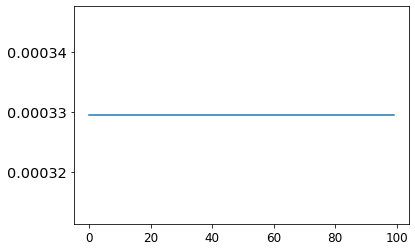

In [110]:
plt.plot(s_mse)

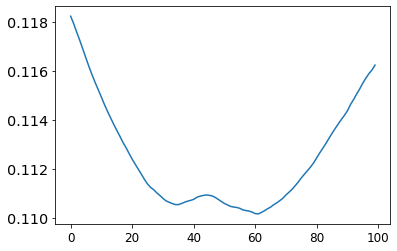

In [111]:
plt.plot(k_mse)

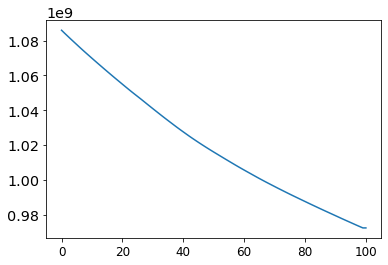

In [112]:
plt.plot(c)

<ipython-input-113-cf963ca4bc30>:18: UserWarning: You have used the `textcoords` kwarg, but not the `xytext` kwarg.  This can lead to surprising results.
  axs[i, 0].annotate(fr"$t=${i * SAVE}", (0.1, 0.4), textcoords="axes fraction", size=30)


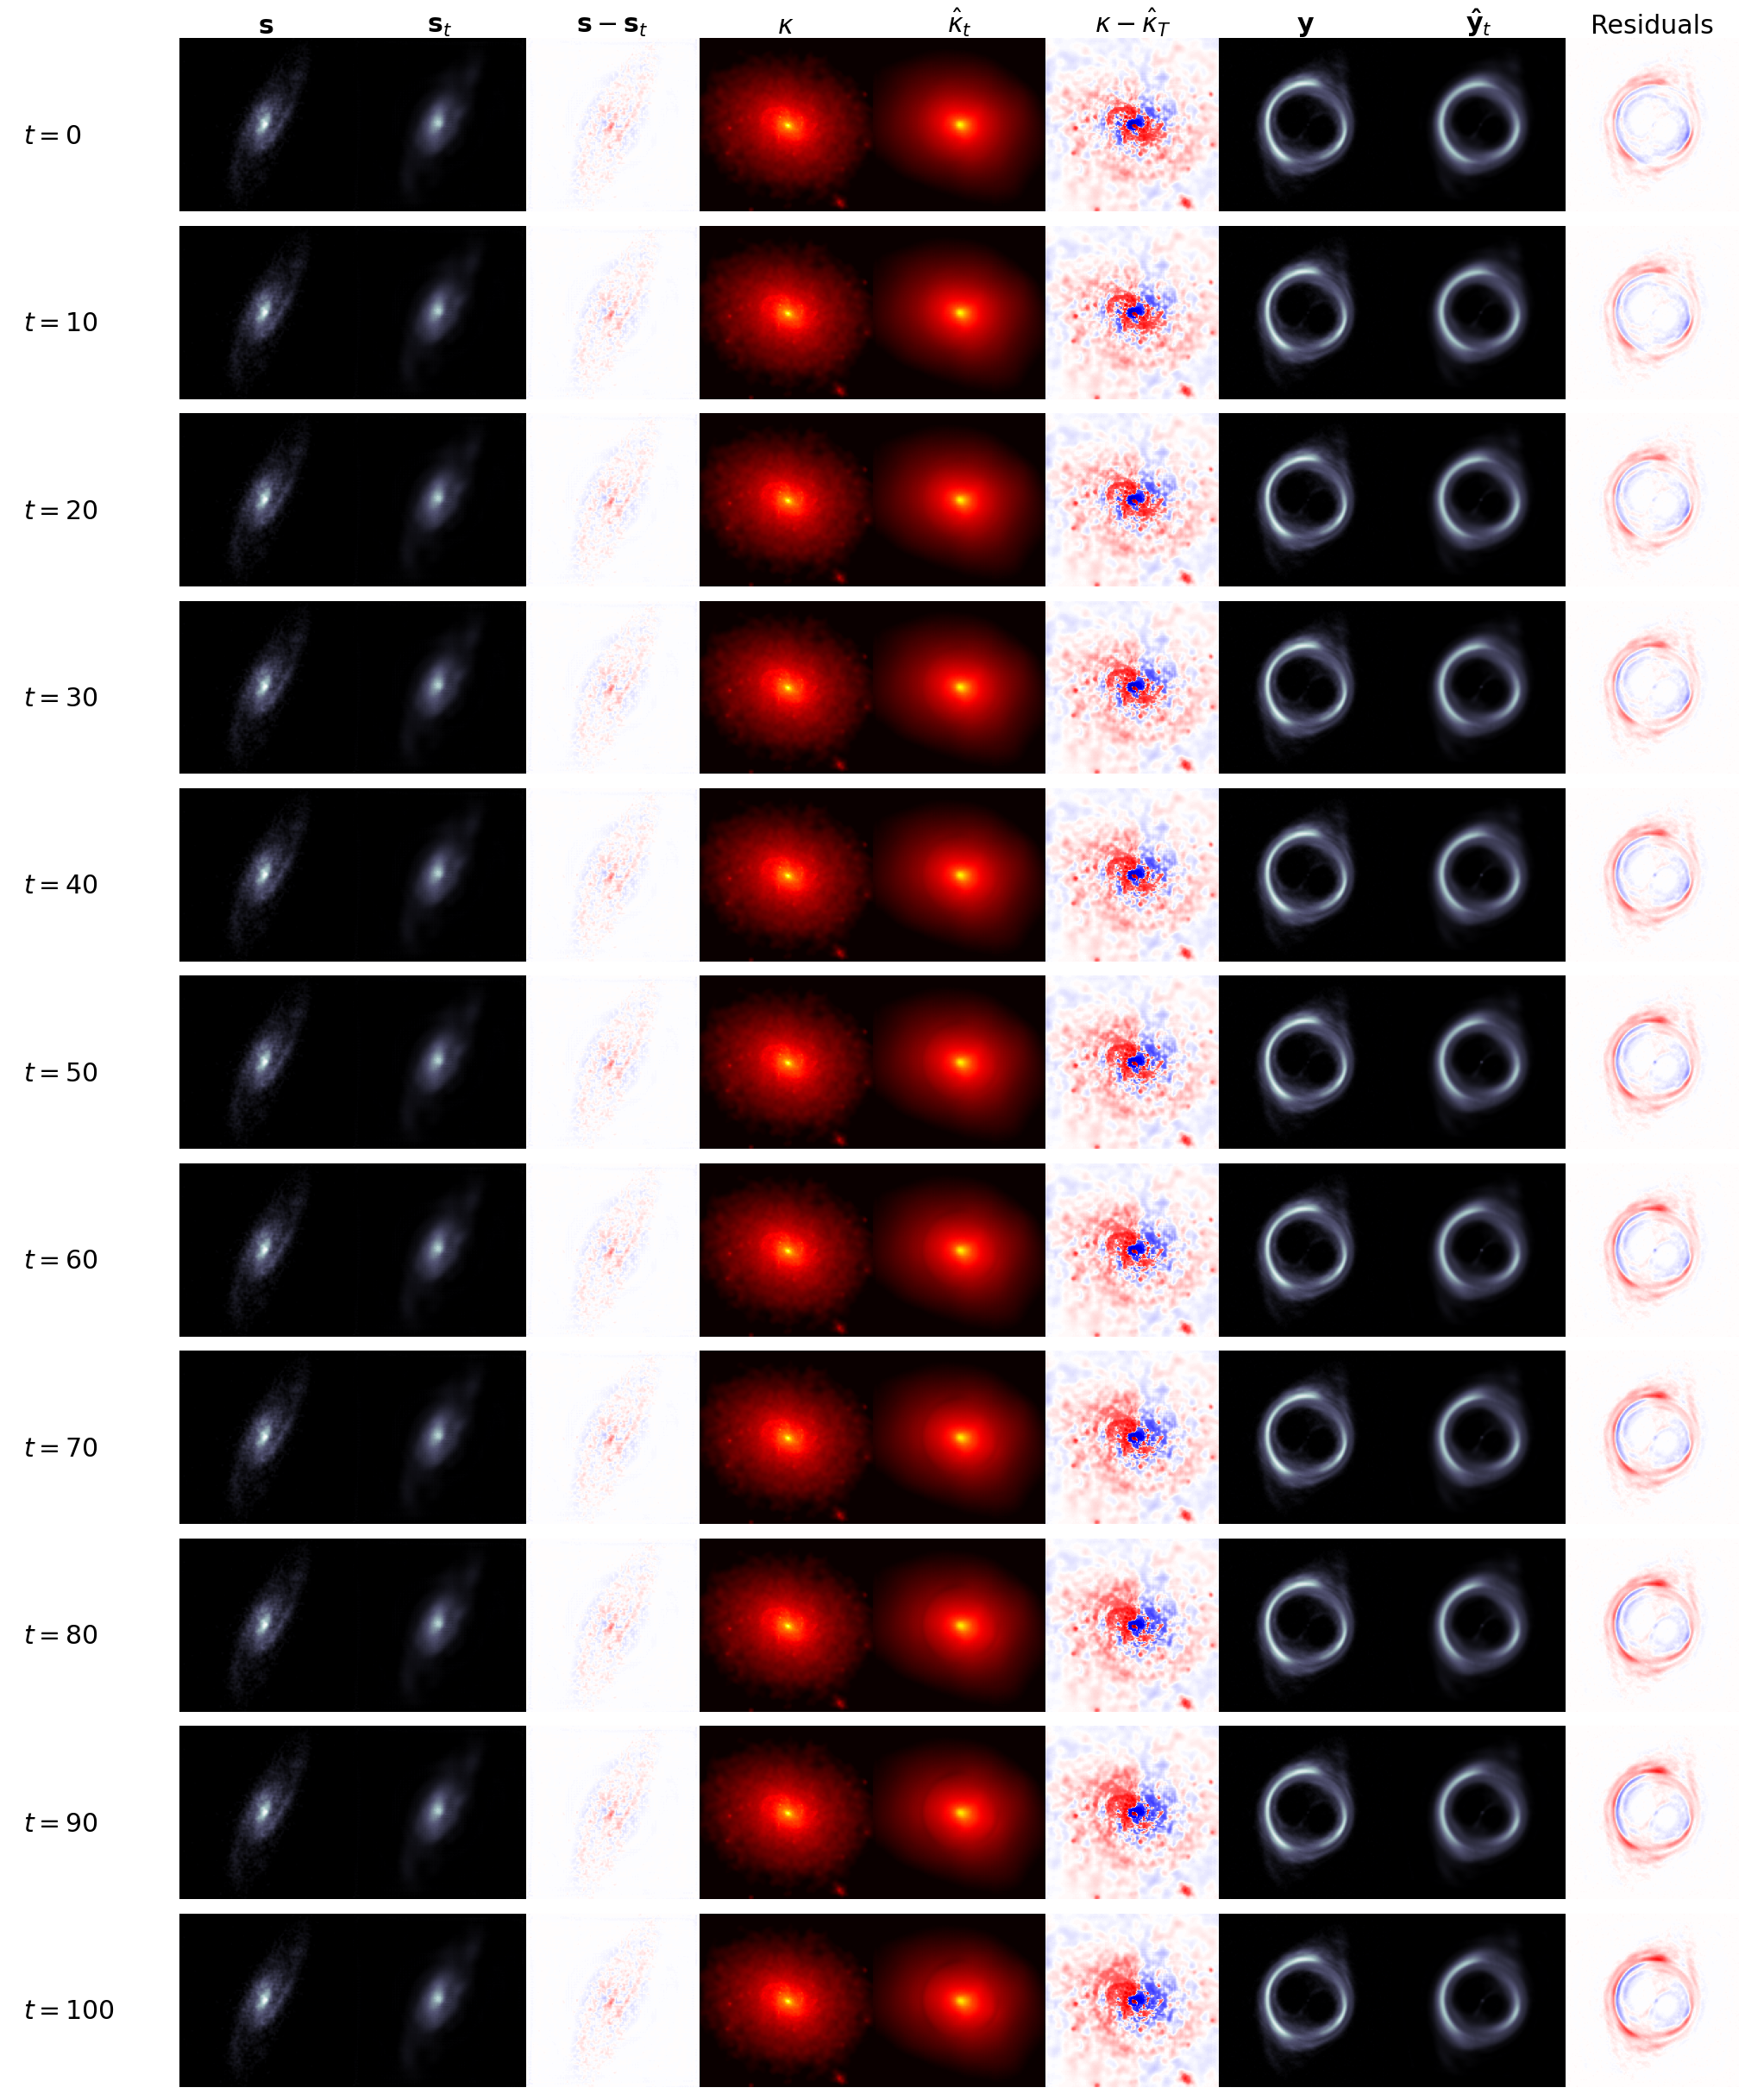

In [113]:
N = 11

fig, axs = plt.subplots(N, 10, figsize=(36, 4 * N))
for i in range(N):
    axs[i, 1].imshow(source, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 2].imshow(s[i][0, ..., 0], cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 3].imshow(source - s[i][0, ..., 0], cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
    axs[i, 4].imshow(kappa, cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 5].imshow(10**k[i][0, ..., 0], cmap="hot", norm=LogNorm(vmin=1e-1, vmax=100), origin="lower")
    axs[i, 6].imshow(kappa - 10**k[i][0, ..., 0], cmap="seismic", norm=SymLogNorm(linthresh=1e-1, base=10, vmax=100, vmin=-100), origin="lower")
    
    axs[i, 7].imshow(lens, cmap="bone", vmin=0, vmax=1, origin="lower")
    axs[i, 8].imshow(y[i][0, ..., 0], cmap="bone", vmin=0, vmax=1,  origin="lower")
    axs[i, 9].imshow(lens - y[i][0, ..., 0], cmap="seismic", vmin=-1, vmax=1, origin="lower")
    
for i in range(N):
    axs[i, 0].annotate(fr"$t=${i * SAVE}", (0.1, 0.4), textcoords="axes fraction", size=30)
    for j in range(10):
        axs[i, j].axis("off")

axs[0, 1].set_title(r"$\mathbf{s}$")
axs[0, 2].set_title(r"$\mathbf{s}_t$")
axs[0, 3].set_title("$\mathbf{s} - \mathbf{s}_t$")
axs[0, 4].set_title("$\kappa$")
axs[0, 5].set_title("$\hat{\kappa}_t$")
axs[0, 6].set_title("$\kappa - \hat{\kappa}_T$")
axs[0, 7].set_title("$\mathbf{y}$")
axs[0, 8].set_title("$\mathbf{\hat{y}}_t$")
axs[0, 9].set_title("Residuals")
plt.subplots_adjust(wspace=0, hspace=0)
# plt.savefig(f"rim_pred_optim3.png")

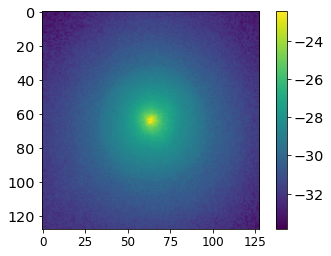

In [277]:
plt.imshow(np.log((kappa_pred - 10**k[-1][0, ..., 0]).numpy().squeeze()**2))
plt.colorbar()

In [297]:
plt.imshow((kappa - 10**k[-1])[0, ..., 0])
plt.colorbar()

TypeError: 'int' object is not subscriptable

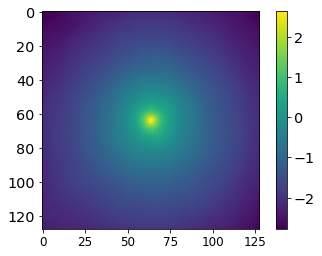

In [265]:
plt.imshow(np.log(k[-1][0, ..., 0]))
plt.colorbar()

(array([177045.,  17255.,   8882.,   6822.,   5122.,   4169.,   3524.,
          3138.,   2873.,   2735.,   2624.,   2709.,   2800.,   3127.,
          3438.,   3071.,   2884.,   2996.,   3398.,   3532.]),
 array([-8.0741628e-04,  4.8609413e-02,  9.8026238e-02,  1.4744307e-01,
         1.9685990e-01,  2.4627672e-01,  2.9569355e-01,  3.4511039e-01,
         3.9452723e-01,  4.4394404e-01,  4.9336088e-01,  5.4277772e-01,
         5.9219456e-01,  6.4161134e-01,  6.9102818e-01,  7.4044502e-01,
         7.8986186e-01,  8.3927870e-01,  8.8869548e-01,  9.3811232e-01,
         9.8752916e-01], dtype=float32),
 <BarContainer object of 20 artists>)

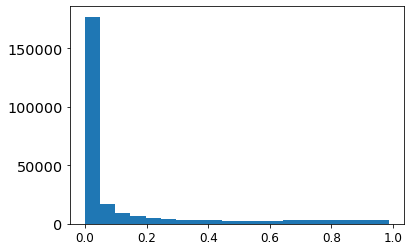

In [176]:
plt.hist(y[0].numpy().ravel(), bins=20)

(array([3.1709000e+04, 8.3759000e+04, 3.6008400e+05, 4.0760650e+07,
        6.5105559e+07, 1.0055138e+07, 6.3477470e+06, 6.9608970e+06,
        4.3382620e+06, 1.7392300e+05]),
 array([-0.8300097 , -0.65256196, -0.47511423, -0.2976665 , -0.12021875,
         0.05722898,  0.23467672,  0.41212445,  0.5895722 ,  0.7670199 ,
         0.94446766], dtype=float32),
 <BarContainer object of 10 artists>)

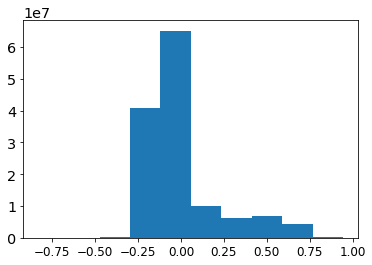

In [184]:
plt.hist((lensed_image - y[-1]).numpy().ravel())

(array([3.1709000e+04, 8.3759000e+04, 3.6008400e+05, 4.0760650e+07,
        6.5105559e+07, 1.0055138e+07, 6.3477470e+06, 6.9608970e+06,
        4.3382620e+06, 1.7392300e+05]),
 array([-0.8300097 , -0.65256196, -0.47511423, -0.2976665 , -0.12021875,
         0.05722898,  0.23467672,  0.41212445,  0.5895722 ,  0.7670199 ,
         0.94446766], dtype=float32),
 <BarContainer object of 10 artists>)

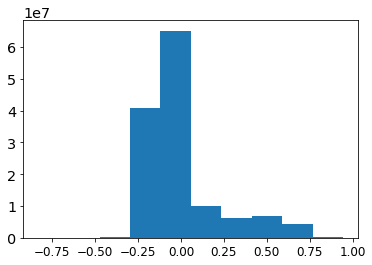

In [185]:
plt.hist((lensed_image - y_pred).numpy().ravel())

In [ ]:
f = h5py.File('yashar.h5', 'w')
g = f.create_group("rim_pred")
g.create_dataset("lens_true",        data=lens)
g.create_dataset("source_true",      data=source)
g.create_dataset("kappa_true",       data=kappa)
g.create_dataset("lens_pred",   data=lens_pred)
g.create_dataset("source_pred", data=source_pred)
g.create_dataset("kappa_pred",  data=kappa_pred)
g.create_dataset("chi_squared", data=tf.reduce_sum(tf.square(lens - lens_pred)/phys.noise_rms**2).numpy())

g = f.create_group("adam_optim")
g.create_dataset("lens",        data=y[-1].numpy().squeeze())
g.create_dataset("source",      data=s[-1].numpy().squeeze())
g.create_dataset("kappa",       data=k[-1].numpy().squeeze())
g.create_dataset("chi_squared", data=c[-1].numpy())
f.close()

In [222]:
tf.reduce_sum(tf.square(lens - lens_pred)/phys.noise_rms**2).numpy()

19257820.0

In [227]:
2*chi_squared*512**2

19257820.0

# HMC

In [13]:
tfd = tfp.distributions

# Target distribution is proportional to: `exp(-x (1 + x))`.
def unnormalized_log_prob(x):
    return -x - x**2.

# Initialize the HMC transition kernel.
num_results = int(10e3)
num_burnin_steps = int(1e3)
adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=unnormalized_log_prob,
        num_leapfrog_steps=3,
        step_size=1.),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
  # Run the chain (with burn-in).
    samples, is_accepted = tfp.mcmc.sample_chain(
      num_results=num_results,
      num_burnin_steps=num_burnin_steps,
      current_state=1.,
      kernel=adaptive_hmc,
      trace_fn=lambda _, pkr: pkr.inner_results.is_accepted)
    return samples

samples = run_chain()
sample_mean = tf.reduce_mean(samples)
sample_stddev = tf.math.reduce_std(samples)
is_accepted = tf.reduce_mean(tf.cast(is_accepted, dtype=tf.float32))

print('mean:{:.4f}  stddev:{:.4f}  acceptance:{:.4f}'.format(
    sample_mean.numpy(), sample_stddev.numpy(), is_accepted.numpy()))

mean:-0.5265  stddev:0.7021  acceptance:0.6351


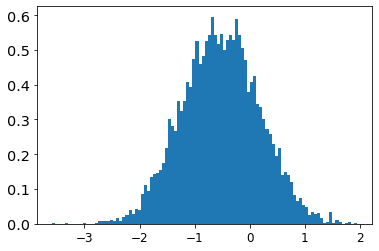

In [23]:
plt.hist(samples.numpy().squeeze(), bins=100, density=True);

# Metropolis adjusted Langevin dynamics

In [24]:
dtype = np.float32
true_mean = dtype([0, 0, 0])
true_cov = dtype([[1, 0.25, 0.25], [0.25, 1, 0.25], [0.25, 0.25, 1]])
num_results = 500
num_chains = 500

# Target distribution is defined through the Cholesky decomposition
chol = tf.linalg.cholesky(true_cov)
target = tfd.MultivariateNormalTriL(loc=true_mean, scale_tril=chol)

# Here we define the volatility function to be non-constant
def volatility_fn(x):
  # Stack the input tensors together
  return 1. / (0.5 + 0.1 * tf.math.abs(x))

# Initial state of the chain
init_state = np.ones([num_chains, 3], dtype=dtype)

# Run MALA with normal proposal for `num_results` iterations for
# `num_chains` independent chains:
states = tfp.mcmc.sample_chain(
    num_results=num_results,
    current_state=init_state,
    kernel=tfp.mcmc.MetropolisAdjustedLangevinAlgorithm(
        target_log_prob_fn=target.log_prob,
        step_size=.1,
        volatility_fn=volatility_fn),
    num_burnin_steps=200,
    num_steps_between_results=1,
    trace_fn=None,
    seed=42)

sample_mean = tf.reduce_mean(states, axis=[0, 1])
x = (states - sample_mean)[..., tf.newaxis]
sample_cov = tf.reduce_mean(
    tf.matmul(x, tf.transpose(x, [0, 1, 3, 2])), [0, 1])

print('sample mean', sample_mean.numpy())
print('sample covariance matrix', sample_cov.numpy())

sample mean [ 0.00575708  0.00233531 -0.00386557]
sample covariance matrix [[1.0019025  0.24767853 0.25109583]
 [0.24767853 0.99839014 0.25406918]
 [0.25109583 0.25406918 0.99916726]]
